<a href="https://colab.research.google.com/github/zxcasd945/Pytorchcolab/blob/main/08_parper_replicating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/nightly/cu113
torch version: 2.0.1+cu118
torchvision version: 0.15.2+cu118


In [8]:
#Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary



[INFO] Couldn't find torchinfo... installing it.


In [9]:
# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3881, done.
remote: Counting objects: 100% (1050/1050), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 3881 (delta 979), reused 943 (delta 932), pack-reused 2831
Receiving objects: 100% (3881/3881), 647.98 MiB | 16.86 MiB/s, done.
Resolving deltas: 100% (2272/2272), done.
Updating files: 100% (248/248), done.


In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [11]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [12]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [13]:
IMG_SIZE = 224
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transforms,
    batch_size = BATCH_SIZE
)


In [14]:
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]
image.shape

torch.Size([3, 224, 224])

In [15]:
#Calculate patch embedding input and output
height = 224
width = 224
color_channels = 3
patch_size = 16
number_of_patches = int((height*width)/patch_size**2)
print(f'Image height(H) :{height}, image width(W):{width} | Number of patches(N):{number_of_patches} with patch_size(P):{patch_size}')

#Input and output shapes of patch embedding layer
embedding_layer_input_shape = (height, width, color_channels)
embedding_layer_output_shape = (number_of_patches, patch_size**2*color_channels)
print(f'Input shape(Single 2D image):{embedding_layer_input_shape}')
print(f'Output shape(Single 2D image flatten to patches):{embedding_layer_output_shape}')

Image height(H) :224, image width(W):224 | Number of patches(N):196 with patch_size(P):16
Input shape(Single 2D image):(224, 224, 3)
Output shape(Single 2D image flatten to patches):(196, 768)


tensor([[[0.9608, 1.0000, 0.9686],
         [0.9608, 1.0000, 0.9686],
         [0.9647, 1.0000, 0.9725],
         ...,
         [0.9961, 1.0000, 0.9686],
         [0.9961, 1.0000, 0.9686],
         [0.9961, 1.0000, 0.9686]],

        [[0.9647, 0.9961, 0.9686],
         [0.9647, 0.9961, 0.9686],
         [0.9686, 1.0000, 0.9725],
         ...,
         [0.9961, 1.0000, 0.9686],
         [0.9961, 1.0000, 0.9686],
         [0.9961, 1.0000, 0.9686]],

        [[0.9686, 0.9961, 0.9686],
         [0.9686, 0.9961, 0.9686],
         [0.9725, 1.0000, 0.9725],
         ...,
         [0.9961, 1.0000, 0.9686],
         [0.9961, 1.0000, 0.9686],
         [0.9961, 1.0000, 0.9686]],

        ...,

        [[0.6078, 0.5765, 0.4745],
         [0.5922, 0.5725, 0.4667],
         [0.5843, 0.5765, 0.4745],
         ...,
         [0.9255, 0.9922, 0.9843],
         [0.9529, 1.0000, 0.9843],
         [0.9647, 1.0000, 0.9765]],

        [[0.6275, 0.6039, 0.4824],
         [0.6039, 0.5843, 0.4667],
         [0.

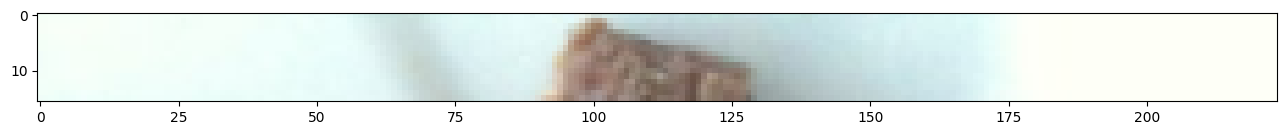

In [16]:
image_permuted = image.permute(1,2,0)
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size,:,:])
image_permuted

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


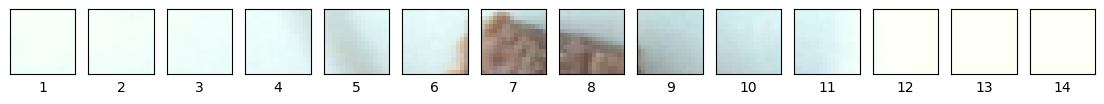

In [17]:
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])


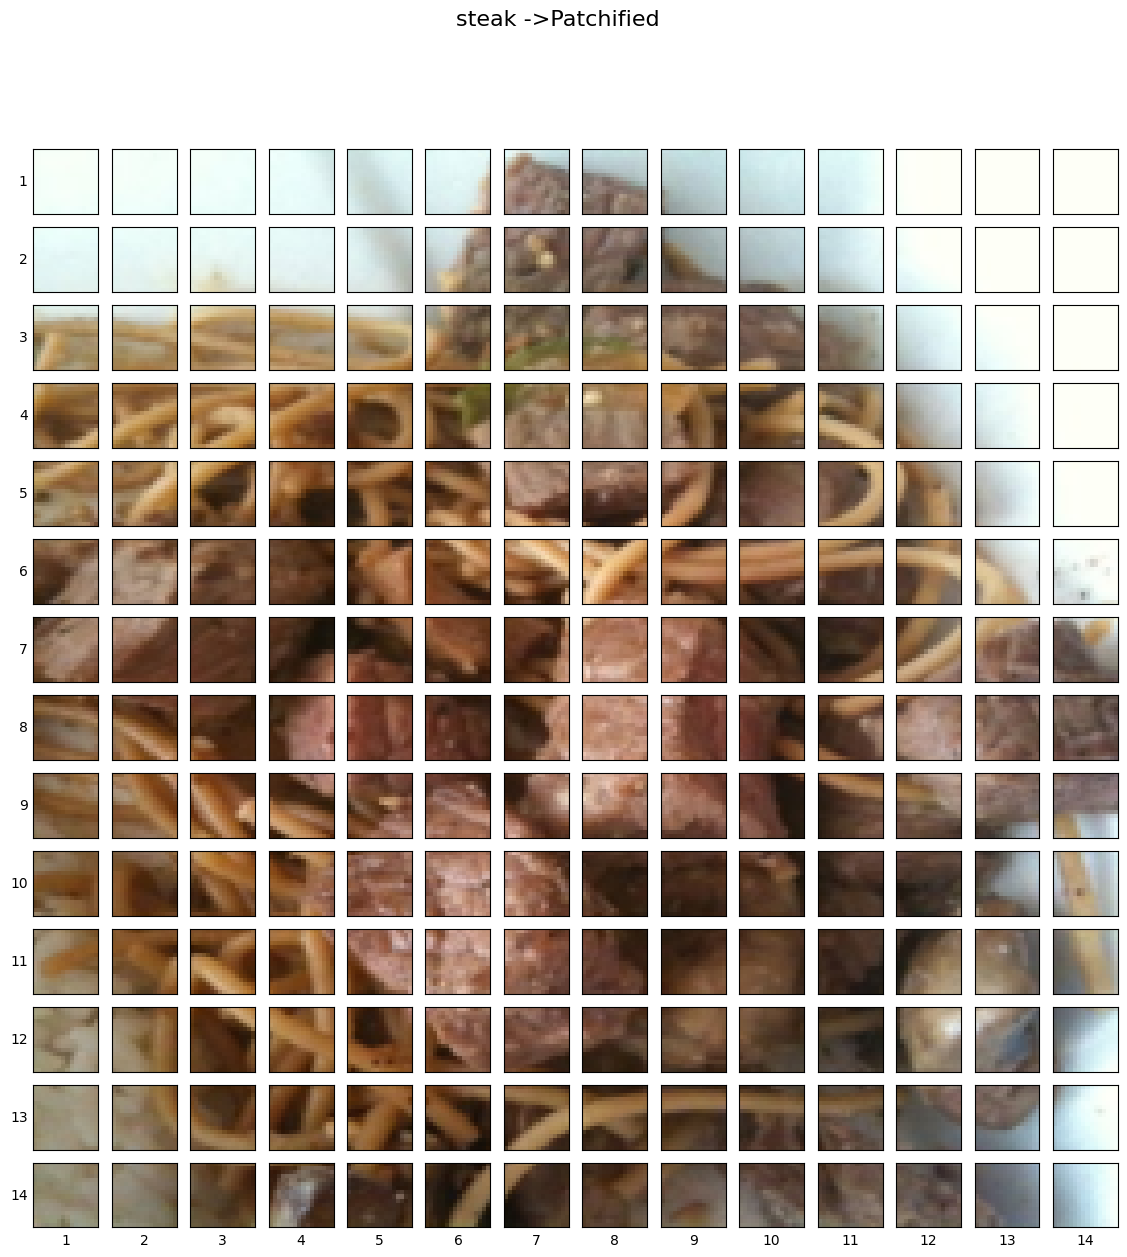

In [18]:
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

for i, height_patch in enumerate(range(0,img_size,patch_size)):
  for j , width_patch in enumerate(range(0,img_size,patch_size)):
    axs[i,j].imshow(image_permuted[height_patch:height_patch+patch_size,
                                     width_patch:width_patch+patch_size,
                                     :])
    axs[i,j].set_ylabel(i+1,
                        rotation='horizontal',
                        horizontalalignment='right',
                        verticalalignment='center')
    axs[i,j].set_xlabel(j+1)
    axs[i,j].set_yticks([])
    axs[i,j].set_xticks([])
    axs[i,j].label_outer()

plt.suptitle(f'{class_names[label]} ->Patchified', fontsize=16)
plt.show()



In [19]:
conv2d = nn.Conv2d(in_channels = 3,
                   out_channels = 768,
                   kernel_size = patch_size,
                   stride = patch_size,
                   padding = 0)


In [20]:
image_out_of_conv = conv2d(image.unsqueeze(0))
single_feature_map= image_out_of_conv[:, 0, :, :]
print(image_out_of_conv.shape)
print(single_feature_map.shape)
print(single_feature_map.requires_grad)


torch.Size([1, 768, 14, 14])
torch.Size([1, 14, 14])
True


In [21]:
flatten = nn.Flatten(start_dim=2, end_dim=3)
image_out_of_conv_flattened= flatten(image_out_of_conv)
image_out_of_conv_flattened.shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0,2,1)
image_out_of_conv_flattened_reshaped.shape

torch.Size([1, 196, 768])

torch.Size([1, 196])


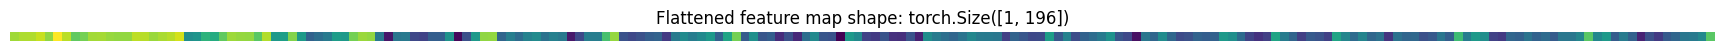

In [22]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)
print(single_flattened_feature_map.shape)
# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [23]:
import torch
from torch import nn
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    # 2. Initialize the class with appropriate variables
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        self.patch_size = patch_size

        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # 6. Make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1)

In [24]:
rand_image_tensor = torch.randn(32, 3, 224, 224) # (batch_size, color_channels, height, width)
patch_embedding = PatchEmbedding(patch_size=16)
patch_embedding_output = patch_embedding(rand_image_tensor)

In [25]:
transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                       nhead=12,
                                                       dim_feedforward=3072,
                                                       dropout=0.1,
                                                       activation="gelu",
                                                       batch_first=True,
                                                       norm_first=True)

In [26]:
from torchinfo import summary

summary(model=transformer_encoder_layer,
        input_size=patch_embedding_output.shape)

Layer (type:depth-idx)                   Output Shape              Param #
TransformerEncoderLayer                  [32, 196, 768]            7,087,872
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 19.27
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 19.27

In [27]:
transformer_encoder = nn.TransformerEncoder(
    encoder_layer=transformer_encoder_layer,
    num_layers=12)

In [28]:
class ViT(nn.Module):
  def __init__(self,
               img_size=224, # from Table 3
               num_channels=3,
               patch_size=16,
               embedding_dim=768, # from Table 1
               dropout=0.1,
               mlp_size=3072, # from Table 1
               num_transformer_layers=12, # from Table 1
               num_heads=12, # from Table 1 (number of multi-head self attention heads)
               num_classes=1000): # generic number of classes (this can be adjusted)
    super().__init__()

    # Assert image size is divisible by patch size
    assert img_size % patch_size == 0, "Image size must be divisble by patch size."

    # 1. Create patch embedding
    self.patch_embedding = PatchEmbedding(in_channels=num_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)

    # 2. Create class token
    self.class_token = nn.Parameter(torch.randn(1, 1, embedding_dim),
                                    requires_grad=True)

    # 3. Create positional embedding
    num_patches = (img_size * img_size) // patch_size**2 # N = HW/P^2
    self.positional_embedding = nn.Parameter(torch.randn(1, num_patches+1, embedding_dim))

    # 4. Create patch + position embedding dropout
    self.embedding_dropout = nn.Dropout(p=dropout)

    # # 5. Create Transformer Encoder layer (single)
    # self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim,
    #                                                             nhead=num_heads,
    #                                                             dim_feedforward=mlp_size,
    #                                                             activation="gelu",
    #                                                             batch_first=True,
    #                                                             norm_first=True)

    # 5. Create stack Transformer Encoder layers (stacked single layers)
    self.transformer_encoder = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                                                              nhead=num_heads,
                                                                                              dim_feedforward=mlp_size,
                                                                                              activation="gelu",
                                                                                              batch_first=True,
                                                                                              norm_first=True), # Create a single Transformer Encoder Layer
                                                     num_layers=num_transformer_layers) # Stack it N times

    # 7. Create MLP head
    self.mlp_head = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  def forward(self, x):
    # Get some dimensions from x
    batch_size = x.shape[0]

    # Create the patch embedding
    x = self.patch_embedding(x)
    # print(x.shape)

    # First, expand the class token across the batch size
    class_token = self.class_token.expand(batch_size, -1, -1) # "-1" means infer the dimension

    # Prepend the class token to the patch embedding
    x = torch.cat((class_token, x), dim=1)
    # print(x.shape)

    # Add the positional embedding to patch embedding with class token
    x = self.positional_embedding + x
    # print(x.shape)

    # Dropout on patch + positional embedding
    x = self.embedding_dropout(x)

    # Pass embedding through Transformer Encoder stack
    x = self.transformer_encoder(x)

    # Pass 0th index of x through MLP head
    x = self.mlp_head(x[:, 0])

    return x

In [29]:
demo_img = torch.randn(1, 3, 224, 224).to(device)
print(demo_img.shape)

# Create ViT
vit = ViT(num_classes=len(class_names)).to(device)
vit(demo_img)

torch.Size([1, 3, 224, 224])


tensor([[0.3767, 0.7242, 0.9033]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [30]:
demo_img = torch.randn(1, 3, 224, 224).to(device)
print(demo_img.shape)

# Create ViT
vit = ViT(num_classes=len(class_names)).to(device)
vit(demo_img)

torch.Size([1, 3, 224, 224])


tensor([[-0.1264,  0.1564, -0.0377]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [31]:
summary(model=ViT(num_classes=3),
        input_size=demo_img.shape)

Layer (type:depth-idx)                        Output Shape              Param #
ViT                                           [1, 3]                    152,064
├─PatchEmbedding: 1-1                         [1, 196, 768]             --
│    └─Conv2d: 2-1                            [1, 768, 14, 14]          590,592
│    └─Flatten: 2-2                           [1, 768, 196]             --
├─Dropout: 1-2                                [1, 197, 768]             --
├─TransformerEncoder: 1-3                     [1, 197, 768]             --
│    └─ModuleList: 2-3                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-2      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-3      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-4      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-5      [1, 197, 76

In [32]:
embedding_dim=768
class_token = nn.Parameter(torch.randn(1, 1, embedding_dim),
                                       requires_grad=True)
class_token.requires_grad

True

In [33]:
batch_size = 32
print(class_token.shape)
class_token.expand(batch_size, -1, -1).shape

torch.Size([1, 1, 768])


torch.Size([32, 1, 768])

In [34]:
patch_size = 16
img_size = 224
num_patches = (img_size*img_size) // patch_size**2
pos_embedding = nn.Parameter(torch.randn(1, num_patches+1, embedding_dim))
pos_embedding.shape

torch.Size([1, 197, 768])